# Project 4 - Image Warping and Mosaicing

### Dependencies

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

## Shoot and digitize pictures

In [2]:
panorama_left = plt.imread('../data/IMG_8357.jpeg')
panorama_right = plt.imread('../data/IMG_8358.jpeg')

## Recover homography

In [3]:
# the points are defined in a json file
with open('../data/points.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

In [4]:
def computeH(im1_pts, im2_pts):
    n = im1_pts.shape[0]
    A = []
    b = []

    for i in range(n):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]

        # Two rows for each correspondence (one for x', one for y')
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])

    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    
    # H is the last column of V (corresponding to the smallest singular value)
    H = V[-1].reshape(3, 3)
    
    # Normalize H to ensure h33 is 1
    H /= H[2, 2]
    
    return H

# Compute the homography matrix using the points from the JSON file
H = computeH(im1_points, im2_points)
print("Computed homography matrix H:")
print(H)

Computed homography matrix H:
[[ 1.78993375e+01  7.52588264e-01 -1.02606471e+04]
 [ 5.08714495e+00  1.49372642e+01 -4.35746743e+03]
 [ 1.30566235e-02  4.11052418e-03  1.00000000e+00]]


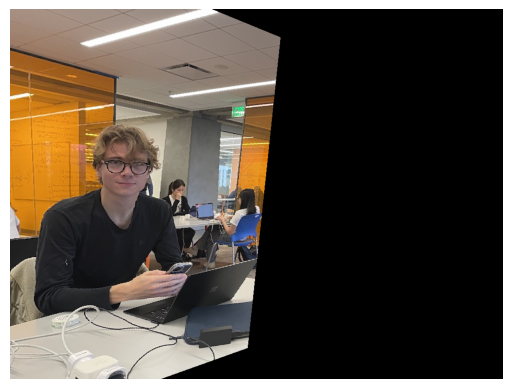

In [7]:
def warp_image(im, H, output_shape):
    # Output image shape
    h, w = output_shape
    
    # Convert the image to float32 for better precision in calculations
    warped_image = np.zeros((h, w, im.shape[2]), dtype=np.float32)
    
    # Invert the homography to map target points to source points
    H_inv = np.linalg.inv(H)
    
    for y in range(h):
        for x in range(w):
            # Map (x, y) in the output image to the corresponding point in the input image
            target_pt = np.array([x, y, 1])
            source_pt = H_inv @ target_pt
            source_pt /= source_pt[2]  # Normalize to homogeneous coordinates
            
            sx, sy = int(source_pt[0]), int(source_pt[1])
            
            # Check if the source point is within bounds of the source image
            if 0 <= sx < im.shape[1] and 0 <= sy < im.shape[0]:
                warped_image[y, x] = im[sy, sx]
    
    # Convert back to uint8 after warping
    return np.clip(warped_image, 0, 255).astype(np.uint8)

# Load the two images
im1 = plt.imread('../data/IMG_8357.jpeg')
im2 = plt.imread('../data/IMG_8358.jpeg')

# Define output shape for the warped image (same as im2 for simplicity)
output_shape = im2.shape[:2]

# Warp im1 using the computed homography
warped_im1 = warp_image(im1, H, output_shape)

# Save or display the warped image
plt.imshow(warped_im1)
plt.axis('off')
plt.show()

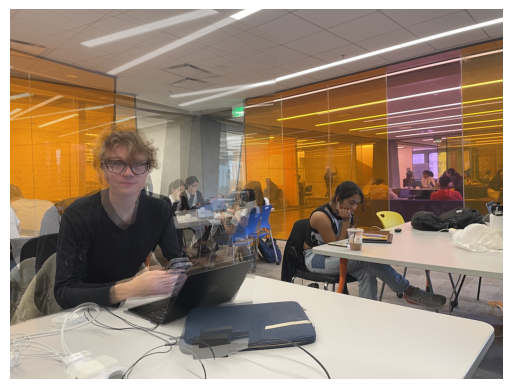

In [9]:
def blend_images(im1, im2):
    # Convert images to float32 for blending
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # Ensure both images are of the same shape
    h, w, _ = im1.shape
    
    # Create a mask where im1 is not black (i.e., where it has been warped)
    mask1 = np.any(im1 != [0, 0, 0], axis=-1)
    
    # Initialize the blended image as float32
    blended_image = np.zeros_like(im1, dtype=np.float32)
    
    # Blend the images: where both images overlap, average the pixel values
    blended_image[mask1] = im1[mask1]
    blended_image[~mask1] = im2[~mask1]
    
    # For overlapping areas, take the average
    overlapping_region = mask1 & (np.any(im2 != [0, 0, 0], axis=-1))
    blended_image[overlapping_region] = (im1[overlapping_region] + im2[overlapping_region]) / 2.0
    
    # Convert back to uint8 after blending
    return np.clip(blended_image, 0, 255).astype(np.uint8)

# Blend the warped im1 with im2
mosaic = blend_images(warped_im1, im2)

# Save or display the final mosaic
plt.imshow(mosaic)
plt.axis('off')
plt.show()